In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from LLM_dialogue_generator import LLMDialogueGenerator
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 从安全感知的图像中选取20个图像（固定）
import sys
sys.path.append("/code/LLM-crime/safety_perception_model/single_model")
from safety_perception_dataset import SafetyPerceptionCLIPDataset
from torch.utils.data import DataLoader

paras = {
    'dataset_path':"/data1/cehou_data/LLM_safety/img_text_data/dataset_baseline_baseline_baseline_baseline_501.pkl",
    'CLIP_model_path': "/data1/cehou_data/LLM_safety/LLM_model/clip_model/model_baseline_baseline_baseline_baseline.pt",
    'variables_save_paths': f"/data1/cehou_data/LLM_safety/middle_variables/test",
    'safety_model_save_path' : f"/data1/cehou_data/LLM_safety/safety_perception_model/",
    'placepulse_datapath': "/data_nas/cehou/LLM_safety/PlacePulse2.0/image_perception.csv",
    'eval_path': "/data1/cehou_data/LLM_safety/eval/",
    'train_type': 'classification',
    'safety_epochs': 100
}

img_feature = np.load(paras['variables_save_paths'] + '/img_feature.npy')

data = pd.read_csv(paras['placepulse_datapath'])
SVI_namelist = pd.read_pickle(paras['dataset_path'])
namelist = pd.DataFrame([SVI_namelist[i]['GSV_name'] for i in range(len(SVI_namelist))],columns=['Image_ID'])
data = namelist.merge(data[data['Category'] == 'safety'], on='Image_ID')

train_len = int(0.7*len(img_feature))
valid_len = len(img_feature) - train_len
train_dataset = SafetyPerceptionCLIPDataset(data[:train_len], img_feature[:train_len], paras)
valid_dataset = SafetyPerceptionCLIPDataset(data[train_len:], img_feature[train_len:], paras)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

FileNotFoundError: [Errno 2] No such file or directory: '/data1/cehou_data/LLM_safety/img_text_data/dataset_baseline_baseline_baseline_baseline_501.pkl'

In [3]:
chatbot = LLMDialogueGenerator(device='cuda:1')

Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Using device: cuda:1


In [4]:
# def get_img(df, idx, GSV_rootpath):
    
#     GSV_name = df.iloc[idx]['panoid']
#     GSV_list = [f"{GSV_rootpath}/{GSV_name[0]}/{GSV_name[1]}/{GSV_name}_{angle}.jpg" for angle in range(0, 360, 90)]
#     for i,path in enumerate(GSV_list):
#         if i == 0:
#             GSV_img = np.array(Image.open(GSV_list[0]))
#         else:
#             GSV_img = np.concatenate((GSV_img, np.array(Image.open(path))), axis=1)

#     # visualization
#     # plt.imshow(GSV_img)
#     # plt.title('GSV from original dataset')
#     # plt.axis('off')
#     return GSV_img

def get_img_placepulse(df, idx, GSV_rootpath):
    
    GSV_name = df.iloc[idx]['panoid']
    GSV_path = f"{GSV_rootpath}/{GSV_name}.jpg"
    GSV_img = np.array(Image.open(GSV_path))

    # visualization
    # plt.imshow(GSV_img)
    # plt.title('GSV from original dataset')
    # plt.axis('off')
    return GSV_img

# GSV_metadata_path = '/data_nas/GoogleSV/metadata/China/HongKong/pano_2024-08-17 13:11:09.125553_23512.p' # Hong Kong SVI
# GSV_metadata = pd.read_pickle(GSV_metadata_path)

GSV_metadata_path = '/data_nas/cehou/LLM_safety/PlacePulse2.0/train_data.csv' # Place Pulse SVI
GSV_metadata = pd.read_csv(GSV_metadata_path) 

In [5]:
# GSV_metadata_npy = np.load('/data_nas/cehou/LLM_safety/PlacePulse2.0/train_data_ls.npy', allow_pickle=True)
# GSV_metadata = pd.DataFrame()
# for i, unit in tqdm(enumerate(GSV_metadata_npy)):
#     a = pd.DataFrame(columns=['Image_ID','safety','lively','beautiful','wealthy','depressing','boring'])
#     a = a.append({'Image_ID':unit['Image_ID'],'safety':unit['labels'][0],'lively':unit['labels'][1],'beautiful':unit['labels'][2],'wealthy':unit['labels'][3],'depressing':unit['labels'][4],'boring':unit['labels'][5]},ignore_index=True)
#     GSV_metadata = GSV_metadata.append(a)

# GSV_metadata = GSV_metadata.reset_index(drop=True)

In [6]:
# GSV_rootpath = "/data_nas/GoogleSV/images/China/HongKong"
GSV_rootpath = "/data_nas/cehou/LLM_safety/PlacePulse2.0/photo_dataset/final_photo_dataset"
random_indices = GSV_metadata.sample(n=1).index.tolist()
# idx = random_indices[0]
idx = 0
GSV_img = get_img_placepulse(GSV_metadata, idx, GSV_rootpath)

In [7]:
# QA process
def count_characters(s):
    return len(s)


def chat_process(question_list):
    for i, question in enumerate(question_list):
        # print(f"chat round {i}")
        if i == 0:
            conversation = chatbot.generate_conversation(result=None, next_question=question[0], image=None)
            answer = chatbot.dialogue(conversation,max_new_tokens=500)
        else:
            if question[1] is not None:
                conversation = chatbot.generate_conversation(answer, question[0], image=True)
                answer = chatbot.dialogue(conversation, GSV_img=question[1],max_new_tokens=500)
            else:
                conversation = chatbot.generate_conversation(result=answer, next_question=question[0], image=None)
                answer = chatbot.dialogue(conversation,max_new_tokens=500)
        # print(f"len of answer: {count_characters(answer)}")
    return answer

# GSV_img = get_img_placepulse(GSV_metadata, 0, GSV_rootpath)

# profile = {
#     "age": 30,
#     "gender": "male",
#     "location": "Hong Kong",
#     "event": "murder"
# }
# question_list = [
#         [f"Please design a {profile['event']}-focused street safety perception system rating scale and list in as much detail as possible the different information that people pay attention to in street perception by looking around the built environment (elements of the urban environment that Street View images can capture). Note that we cannot provide subjective information about residents' personal experiences, so look for key points from the objective environment, please answer this question within 300 words.", None],
#         ["Based on your answers, evaluate the safety perception brought to you by the street scenes in the panoramic street view image one by one. Please answer this question within 300 words.", GSV_img],
#         [f"When evaluating the safety perception of specific criminal behaviors, it is important to consider the sensitivity of different demographic groups to their environment. For {profile['gender']}, which parts of the image would you emphasize? Please answer this question within 300 words.", None],
#         [f"For individuals around the age of {profile['age']}, what factors in the image do you think would impact their sense of safety? Please answer this question within 300 words.", None],
#         [f"When discussing the safety perception in {profile['location']}, what is the characteristics of the built environment, and how these characteristics will influence people's safety perception? Please answer this question within 300 words.", None],
#         [f"In assessing safety perception regarding {profile['event']}, what do you believe are the important part of the image? Please answer this question within 300 words.", None],
#         [f"Please help me to summarize all the information you have provided and provide a comprehensive evaluation of the safety perception in this location, please answer this question from the perspective of age {profile['age']}, gender {profile['gender']}, location {profile['location']}, and perception for the special event ({profile['event']}). Please answer this question within 300 words.", None],
#         ["Taking into account all the above points, what is your overall view of the safety perception in this location? Please answer this question within 300 words.", None]
#         # ["Now, we try to focus on the females, if you were to evaluate the safety perception of women in their 30s, and rate the results from 1 to 10, with 1 being the least safe and 10 being the safest, what results would you give? Please note that if the information given in the image is insufficient to reflect the characteristics, it will be marked 'not applicable'.", GSV_img]
#     ]

# reply_text = chat_process(question_list)

# answer = [i.split("<\\s> [INST]")[0] for i in reply_text.split(" [/INST] ")][1:]
# question = [reply_text.split(" [/INST] ")[0][7:]] + [i.split("<\\s> [INST]")[1] for i in reply_text.split(" [/INST] ")[1:-1]]

In [14]:
profile_list = [
    {
    "age": 30,
    "gender": "male",
    "location": "Hong Kong",
    "event": "murder"
    },
    {
    "age": 30,
    "gender": "female",
    "location": "Hong Kong",
    "event": "murder"
    }
]

profile = {
    "age": 30,
    "gender": "male",
    "location": "Hong Kong",
    "event": "murder"
    }

reply_list = []

for i in range(3):
    GSV_img = get_img_placepulse(GSV_metadata, i, GSV_rootpath)
    question_list_a = [
            [f"Please design a {profile['event']}-focused street safety perception system rating scale and list in as much detail as possible the different information that people pay attention to in street perception by looking around the built environment (elements of the urban environment that Street View images can capture). Note that we cannot provide subjective information about residents' personal experiences, so look for key points from the objective environment, please answer this question within 300 words.", None],
            ["Based on your answers, evaluate the safety perception brought to you by the street scenes in the panoramic street view image one by one. Please answer this question within 300 words.", GSV_img],
            [f"When evaluating the safety perception of specific criminal behaviors, it is important to consider the sensitivity of different demographic groups to their environment. For {profile['gender']}, which parts of the image would you emphasize? Please answer this question within 300 words.", None],
            [f"For individuals around the age of {profile['age']}, what factors in the image do you think would impact their sense of safety? Please answer this question within 300 words.", None],
            [f"When discussing the safety perception in {profile['location']}, what is the characteristics of the built environment, and how these characteristics will influence people's safety perception? Please answer this question within 300 words.", None],
            [f"In assessing safety perception regarding {profile['event']}, what do you believe are the important part of the image? Please answer this question within 300 words.", None],
            [f"Please help me to summarize all the information you have provided and provide a comprehensive evaluation of the safety perception in this location, please answer this question from the perspective of age {profile['age']}, gender {profile['gender']}, location {profile['location']}, and perception for the special event ({profile['event']}). Please answer this question within 300 words.", None]
            # ["Taking into account all the above points, what is your overall view of the safety perception in this location? Please answer this question within 300 words.", None]
            # ["Now, we try to focus on the females, if you were to evaluate the safety perception of women in their 30s, and rate the results from 1 to 10, with 1 being the least safe and 10 being the safest, what results would you give? Please note that if the information given in the image is insufficient to reflect the characteristics, it will be marked 'not applicable'.", GSV_img]
        ]
    question_list_b = [
            [f"Please design a {profile['event']}-focused street safety perception system rating scale and list in as much detail as possible the different information that people pay attention to in street perception by looking around the built environment (elements of the urban environment that Street View images can capture). Note that we cannot provide subjective information about residents' personal experiences, so look for key points from the objective environment, please answer this question within 300 words.", None],
            ["Based on your answers, evaluate the safety perception brought to you by the street scenes in the panoramic street view image one by one. Please answer this question within 300 words.", GSV_img],
            [f"Please help me to provide a comprehensive evaluation of the safety perception in this location, please answer this question from the perspective of age {profile['age']}, gender {profile['gender']}, location {profile['location']}, and perception for the special event ({profile['event']}). Please answer this question within 300 words.", None]
            # ["Taking into account all the above points, what is your overall view of the safety perception in this location? Please answer this question within 300 words.", None]
            # ["Now, we try to focus on the females, if you were to evaluate the safety perception of women in their 30s, and rate the results from 1 to 10, with 1 being the least safe and 10 being the safest, what results would you give? Please note that if the information given in the image is insufficient to reflect the characteristics, it will be marked 'not applicable'.", GSV_img]
        ]
    reply_text_a = chat_process(question_list_a)
    reply_list.append(reply_text_a)
    reply_text_b = chat_process(question_list_b)
    reply_list.append(reply_text_b)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
Expanding inputs for image tokens in LLaVa-NeXT should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Expanding inputs for image tokens in LLaVa-NeXT should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the confi

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 定义两个字符串

def cal_text_similarity(str_list):
    # 将文本转换为tf-idf特征
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform(str_list)
    # 计算两个字符串之间的余弦相似度
    similarity = cosine_similarity(tfidf)
    return similarity

In [18]:
answer_list = []
question_list = []
sim_mat_a_list = []
sim_mat_q_list = []
for reply_text in reply_list:
    answer = [i.split("<\\s> [INST]")[0] for i in reply_text.split(" [/INST] ")][1:]
    question = [reply_text.split(" [/INST] ")[0][7:]] + [i.split("<\\s> [INST]")[1] for i in reply_text.split(" [/INST] ")[1:-1]]
    answer_list.append(answer)
    question_list.append(question)
    sim_mat_a = cal_text_similarity(answer)
    sim_mat_q = cal_text_similarity(question)
    sim_mat_a_list.append(sim_mat_a)
    sim_mat_q_list.append(sim_mat_q)

In [27]:
import math
from collections import Counter

def calculate_entropy(text):
    # 统计每个字符的频率
    freq = Counter(text)
    total_chars = len(text)
    
    # 计算信息熵
    entropy = -sum((count / total_chars) * math.log2(count / total_chars) for count in freq.values())
    
    return entropy

# 示例文字
text = "计算一段文字的信息熵"
entropy = calculate_entropy(answer_list[4][-1])
print(f"信息熵: {entropy}")
entropy = calculate_entropy(answer_list[5][-1])
print(f"信息熵: {entropy}")

信息熵: 4.275932852420453
信息熵: 4.265130918144678


In [28]:
print(answer_list[4][-1])

Based on the information provided, the safety perception of a male aged 30 in Hong Kong for a special event such as murder would likely be influenced by several factors.

Firstly, the presence of people in the image would be an important factor to consider. If there are no people visible in the image, it may suggest that the area is not frequently visited or that it is not a safe place to be.

Secondly, the lighting in the image would also be an important factor to consider. Poorly lit areas can make people feel more vulnerable and at risk of criminal activity.

Thirdly, the presence of any suspicious or unusual activity in the image would also be an important factor to consider. For example, if there are any individuals acting in a suspicious manner or if there are any abandoned or vandalized properties, it may suggest that the area is not safe.

Fourthly, the overall condition of the area would also be an important factor to consider. If the area appears to be poorly maintained or ne

In [31]:
print(answer_list[5][-1])

As a 30-year-old male living in Hong Kong, my perception of safety in this location would likely be influenced by several factors.

Firstly, the age and gender of the person can impact their perception of safety. As a young male, I may be more concerned about personal safety and the risk of crime than an older female, for example.

Secondly, the location of the street can impact my perception of safety. Hong Kong is a densely populated urban area, and as such, there may be a higher risk of crime in certain areas compared to more suburban or rural areas.

Thirdly, the perception of safety can be influenced by the presence of certain elements in the built environment. In the panoramic street view image, the street appears to be well-maintained and orderly, with clear rules and regulations in place to manage traffic flow and maintain order. The presence of a red car parked on the side of the street, the well-lit street, the relatively quiet street, and the traffic light all suggest that t

In [55]:
sim_diff_sex_df = pd.DataFrame()

for j in range(len(answer_list)//2):
    sim_diff_sex_ls = []
    for i in range(len(answer_list[0])):
        sim_diff_sex = cal_text_similarity([answer_list[2*j][i], answer_list[2*j+1][i]])[0,1]
        sim_diff_sex_ls.append([sim_diff_sex])
    sim_diff_sex_df = pd.concat([sim_diff_sex_df, pd.DataFrame(sim_diff_sex_ls, columns=[f"{2*j}_{2*j+1}"])], axis=1)

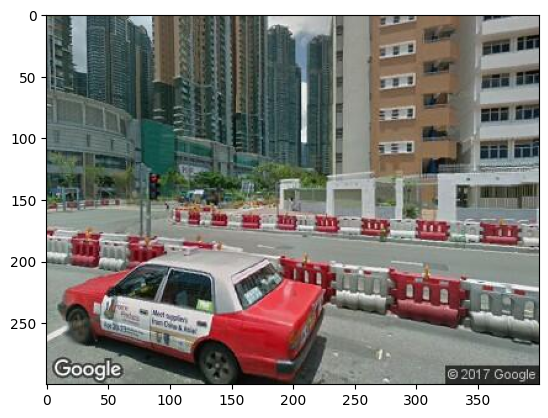

In [68]:
plt.imshow(get_img_placepulse(GSV_metadata, 2, GSV_rootpath))

In [72]:
def cal_img_similarity(dataset, GSV_rootpath, img1_idx, img2_idx):
    img1 = get_img_placepulse(dataset, img1_idx, GSV_rootpath)
    img2 = get_img_placepulse(dataset, img2_idx, GSV_rootpath)
    img1_flat = img1.flatten().reshape(1, -1)
    img2_flat = img2.flatten().reshape(1, -1)
    img_similarity = cosine_similarity(img1_flat, img2_flat)
    return img_similarity[0][0]

cal_img_similarity(GSV_metadata, GSV_rootpath, 2, 1)

0.8304662707723085

<Axes: >

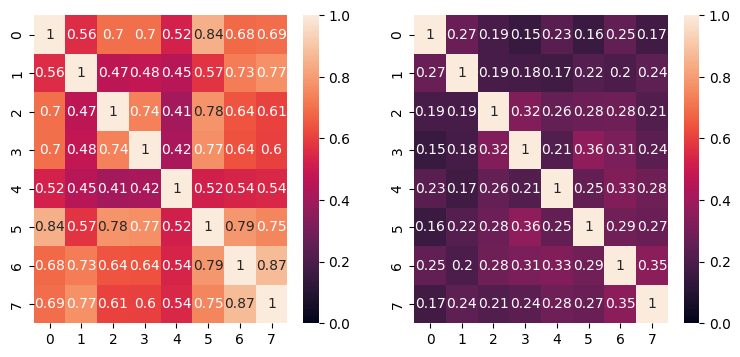

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(9,4))

sns.heatmap(sim_mat_a, annot=True,vmin=0,vmax=1, ax=ax[0])
sns.heatmap(sim_mat_q, annot=True,vmin=0,vmax=1, ax=ax[1])

In [69]:
print(answer[6])

Based on the information provided, the safety perception of a 30-year-old male in Hong Kong regarding a special event (murder) can be evaluated as follows:

Firstly, the presence of well-lit streets and sidewalks is important for a sense of security. The street scene in the image appears to be well-lit, which can help deter criminal activity and provide a sense of security for pedestrians and drivers.

Secondly, the level of pedestrian activity can also impact people's perception of safety. The street scene in the image appears to have moderate pedestrian activity, which can make people feel more secure, as there are more people around to witness and report any suspicious behavior.

Thirdly, the availability of surveillance cameras can provide a sense of security, as they can help deter crime and provide evidence in the event of a crime. The street scene in the image does not provide information on the presence of surveillance cameras.

Fourthly, the design of streets, including the pl

In [5]:
# question_list = [
#     ["Please design a murder-focused street safety perception system rating scale and list in as much detail as possible the different information that people pay attention to in street perception by looking around the built environment (elements of the urban environment that Street View images can capture). Note that we cannot provide subjective information about residents' personal experiences, so look for key points from the objective environment", None],
#     ["Based on your answers, evaluate the safety perception brought to you by the street scenes in the panoramic street view image one by one.", GSV_img],
#     ["Based on your analysis, if you were to rate the results of your analysis from 1 to 10, with 1 being the least safe and 10 being the safest, what results would you give? Please note that if the information given in the image is insufficient to reflect the characteristics, it will be marked 'not applicable'.", None],
#     ["Very good! Based on your result, if you were to evaluate the safety perception of men in their 30s, and rate the results from 1 to 10, with 1 being the least safe and 10 being the safest, what results would you give? Please note that if the information given in the image is insufficient to reflect the characteristics, it will be marked 'not applicable'.", GSV_img],
#     ["Now, we try to focus on the females, if you were to evaluate the safety perception of women in their 30s, and rate the results from 1 to 10, with 1 being the least safe and 10 being the safest, what results would you give? Please note that if the information given in the image is insufficient to reflect the characteristics, it will be marked 'not applicable'.", GSV_img]
# ]

In [22]:
# QA process
def count_characters(s):
    return len(s)


def chat_process(question_list):
    for i, question in enumerate(question_list):
        # print(f"chat round {i}")
        if i == 0:
            conversation = chatbot.generate_conversation(result=None, next_question=question[0], image=None)
            answer = chatbot.dialogue(conversation,max_new_tokens=500)
        else:
            if question[1] is not None:
                conversation = chatbot.generate_conversation(answer, question[0], image=True)
                answer = chatbot.dialogue(conversation, GSV_img=question[1],max_new_tokens=500)
            else:
                conversation = chatbot.generate_conversation(result=answer, next_question=question[0], image=None)
                answer = chatbot.dialogue(conversation,max_new_tokens=500)
    return answer

random_indices = GSV_metadata.sample(n=100).index.tolist()
# idx = random_indices[0]

GSV_rootpath = "/data_nas/GoogleSV/images/China/HongKong"
profile = {
    "age": 30,
    "gender": "male",
    "location": "Hong Kong",
    "event": "murder"
}
answer_list = []
question_list = [
    [f"Please design a {profile['event']}-focused street safety perception system rating scale and list in as much detail as possible the different information that people pay attention to in street perception by looking around the built environment (elements of the urban environment that Street View images can capture). Note that we cannot provide subjective information about residents' personal experiences, so look for key points from the objective environment", None],
    ["Based on your answers, evaluate the safety perception brought to you by the street scenes in the panoramic street view image one by one.", GSV_img],
    [f"When evaluating the safety perception of specific criminal behaviors, it is important to consider the sensitivity of different demographic groups to their environment. For {profile['gender']}, which parts of the image would you emphasize?", None],
    [f"For individuals around the age of {profile['age']}, what factors in the image do you think would impact their sense of safety?", None],
    [f"When discussing the safety perception in {profile['location']}, what is the characteristics of the built environment, and how these characteristics will influence people's safety perception?", None],
    [f"In assessing safety perception regarding {profile['event']}, what do you believe are the important part of the image?", None],
    ["Based on your answers, evaluate the safety perception brought to you by the street scenes in the panoramic street view image one by one.", None],
    ["Taking into account all the above points, what is your overall view of the safety perception in this location?", None]
    # ["Now, we try to focus on the females, if you were to evaluate the safety perception of women in their 30s, and rate the results from 1 to 10, with 1 being the least safe and 10 being the safest, what results would you give? Please note that if the information given in the image is insufficient to reflect the characteristics, it will be marked 'not applicable'.", GSV_img]
]

for idx in random_indices:
    GSV_img = get_img(idx, GSV_rootpath)
    answer = chat_process(question_list)
    answer_list.append([idx, answer])

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

KeyboardInterrupt: 

In [25]:
def generate_dataset_unit(GSV_idx, GSV_name, GSV_rootpath, answer, profile):
    dataset_unit = {
    "GSV_idx": GSV_idx,
    "GSV_name": GSV_name,
    "GSV_path":[f"{GSV_rootpath}/{GSV_name[0]}/{GSV_name[1]}/{GSV_name}_{angle}.jpg" for angle in range(0, 360, 90)],
    "text_description": answer,
    "age":profile['age'],
    "gender": profile['gender'],
    "location": profile['location'],
    "event": profile['event']
    }
    return dataset_unit

In [31]:
import pickle

dataset_list = []
for answer in answer_list:
    GSV_idx = answer[0]
    GSV_name = GSV_metadata.iloc[GSV_idx]['panoid']
    GSV_rootpath = "/data_nas/GoogleSV/images/China/HongKong"
    text_expression = answer[1]
    dataset_list.append(generate_dataset_unit(GSV_idx, GSV_name, GSV_rootpath, text_expression, profile))

with open('/data_nas/cehou/LLM_safety/dataset_list.pkl', 'wb') as f:
    pickle.dump(dataset_list, f)

In [27]:
dataset_list

[{'GSV_idx': 251698,
  'GSV_name': 'WQNDkBzoSGcjurlgcfILlg',
  'GSV_path': ['/data_nas/GoogleSV/images/China/HongKong/W/Q/WQNDkBzoSGcjurlgcfILlg_0.jpg',
   '/data_nas/GoogleSV/images/China/HongKong/W/Q/WQNDkBzoSGcjurlgcfILlg_90.jpg',
   '/data_nas/GoogleSV/images/China/HongKong/W/Q/WQNDkBzoSGcjurlgcfILlg_180.jpg',
   '/data_nas/GoogleSV/images/China/HongKong/W/Q/WQNDkBzoSGcjurlgcfILlg_270.jpg'],
  'text_description': "[INST] Please design a murder-focused street safety perception system rating scale and list in as much detail as possible the different information that people pay attention to in street perception by looking around the built environment (elements of the urban environment that Street View images can capture). Note that we cannot provide subjective information about residents' personal experiences, so look for key points from the objective environment [/INST] Street Safety Perception Rating Scale:\n\n1. Lighting:\n* Adequate street lighting\n* Insufficient street lighting\

In [19]:
GSV_idx = idx
GSV_name = GSV_metadata.iloc[idx]['panoid']
GSV_rootpath = "/data_nas/GoogleSV/images/China/HongKong"
answer = answer_list[0]

# create dataset
dataset_list = []
for i in range(10):
    dataset_list.append(generate_dataset_unit(GSV_idx, GSV_name, GSV_rootpath, answer, profile))

In [20]:
dataset_list

[{'GSV_idx': 267920,
  'GSV_name': 'h2v7z0MUgrjZmOICNi8Y2w',
  'GSV_path': ['/data_nas/GoogleSV/images/China/HongKong/h/2/h2v7z0MUgrjZmOICNi8Y2w_0.jpg',
   '/data_nas/GoogleSV/images/China/HongKong/h/2/h2v7z0MUgrjZmOICNi8Y2w_90.jpg',
   '/data_nas/GoogleSV/images/China/HongKong/h/2/h2v7z0MUgrjZmOICNi8Y2w_180.jpg',
   '/data_nas/GoogleSV/images/China/HongKong/h/2/h2v7z0MUgrjZmOICNi8Y2w_270.jpg'],
  'text_description': "[INST] Please design a murder-focused street safety perception system rating scale and list in as much detail as possible the different information that people pay attention to in street perception by looking around the built environment (elements of the urban environment that Street View images can capture). Note that we cannot provide subjective information about residents' personal experiences, so look for key points from the objective environment [/INST] Street Safety Perception Rating Scale:\n\n1. Lighting:\n* Adequate street lighting\n* Insufficient street lighting\

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# generate a dataset for pytorch
# for idx, answer in answer_list:
class GSVImageDataset(Dataset):
    def __init__(self, metadata, images, transform=None):
        self.metadata = metadata
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        label = self.metadata.iloc[idx]['id']
        return image, label

# Assuming GSV_img is a list of images corresponding to the metadata
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = GSVImageDataset(metadata=GSV_metadata, images=[GSV_img], transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

In [8]:
for i in range(len(answer_list)):
    print(f"GSV index: {answer_list[i][0]}")
    print(f"Answer: {answer_list[i][1]} \n")

GSV index: 89540
Answer: [INST] Please design a murder-focused street safety perception system rating scale and list in as much detail as possible the different information that people pay attention to in street perception by looking around the built environment (elements of the urban environment that Street View images can capture). Note that we cannot provide subjective information about residents' personal experiences, so look for key points from the objective environment [/INST] Street Safety Perception Rating Scale:

1. Lighting:
* Adequate street lighting
* Insufficient street lighting
* Poorly placed street lighting
* Overhead street lighting
* Street lighting with motion sensors
2. Pedestrian walkways:
* Wide, well-maintained walkways
* Narrow, poorly maintained walkways
* Lack of walkways
* Walkways with obstructions
3. Traffic calming measures:
* Speed bumps
* Traffic circles
* Traffic signs and signals
* Road markings
4. Visibility:
* Clear line of sight
* Obstructed line of

In [87]:
import re
def tidy_df(answer_list, answer_idx):
    '''
    answer index: 4 for male, 5 for female
    '''
    df = pd.DataFrame(columns=['category', 'score', 'explanation'])
    for line in answer_list[1].split(' [/INST] ')[answer_idx].split('\n'):
        pattern = r'^\d+'
        if re.match(pattern, line):
            # print(line)
            number = re.search(r'^\d+', line).group()
            category = re.search(r'\d+\.\s+([^:]+):', line).group(1)
            if re.search(r'(\d+/\d+)', line) is None:
                score = re.search(r':\s*(Not applicable)', line).group(1)
            else:
                score = re.search(r'(\d+/\d+)', line).group(1)
            explanation = re.search(r'\((.*?)\)', line).group(1)
            df = df.append({'category': category, 'score': score, 'explanation': explanation}, ignore_index=True)
            # print(f"number: {number}, category: {category}, score: {score}, explanation: {explanation}")
        
    df = df.T.reset_index(drop=True)
    df.columns = df.iloc[0]
    df = df.drop(0)
    df['idx'] = answer_list[0]
    if answer_idx == 4: # male
        df['gender'] = 'male'
    elif answer_idx == 5:
        df['gender'] = 'female'
    
    return df

all_df = pd.DataFrame()
for i in range(len(answer_list)):
    df_male = tidy_df(answer_list[i], 4)
    df_female = tidy_df(answer_list[i], 5)
    df_group = pd.concat([df_male,df_female],axis=0)
    all_df = pd.concat([all_df, df_group], axis=0)

In [88]:
all_df

,idx,gender
1,607891,male
2,607891,male
1,607891,female
2,607891,female
1,577194,male
...,...,...
2,515761,female
1,638950,male
2,638950,male
1,638950,female


In [22]:
import re

text = '1. Lighting: 8/10 (Adequate lighting contributes to a sense of safety.)'

# 提取编号
number = re.search(r'^\d+', text).group()

# 提取类别
category = re.search(r'\d+\.\s+([^:]+):', text).group(1)

# 提取评分
score = re.search(r'(\d+/\d+)', text).group(1)

# 提取解释
explanation = re.search(r'\((.*?)\)', text).group(1)

print(f"编号: {number}")
print(f"类别: {category}")
print(f"评分: {score}")
print(f"解释: {explanation}")

编号: 1
类别: Lighting
评分: 8/10
解释: Adequate lighting contributes to a sense of safety.


In [16]:
answer_list[0][1].split(' [/INST] ')[5].split('\n')


["Based on the analysis provided, here's a rating for each element in the image from the perspective of a woman in her 30s:",
 '',
 '1. Lighting: 8/10 (Adequate lighting contributes to a sense of safety.)',
 '2. Pedestrian walkways: 9/10 (Wide and well-maintained sidewalks contribute to a sense of safety.)',
 '3. Traffic calming measures: 4/10 (No visible traffic calming measures could be a concern for safety perception.)',
 '4. Visibility: 8/10 (Clear visibility of street signs and markings contributes to a sense of safety.)',
 '5. Surveillance: 4/10 (No visible surveillance cameras or security personnel could be a concern for safety perception.)',
 '6. Landscaping: 9/10 (Well-maintained landscaping contributes to a sense of safety and orderliness.)',
 '7. Fencing and barriers: 5/10 (No visible fencing or barriers could be a concern for safety perception.)',
 '8. Street furniture: 8/10 (The presence of benches and trash cans contributes to a sense of safety and orderliness.)',
 '9. Gr

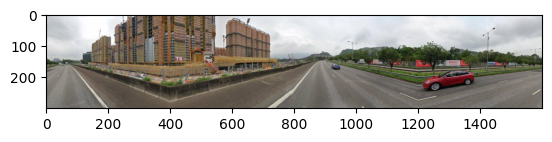

In [11]:
answer_list[0][1]
plt.imshow(get_img(answer_list[0][0]))
plt.show()

In [8]:
tem = answer.split('<\\s>')
tem[3].split(' [/INST] ')[1].split('\n')

["Based on the analysis provided, here's a rating for each element in the image from the perspective of a man in his 30s:",
 '',
 '1. Lighting: 8/10 (Adequate lighting contributes to a sense of safety.)',
 '2. Pedestrian walkways: 9/10 (Wide and well-maintained sidewalks contribute to a sense of safety.)',
 '3. Traffic calming measures: 4/10 (No visible traffic calming measures could be a concern for safety perception.)',
 '4. Visibility: 8/10 (Clear visibility of street signs and markings contributes to a sense of safety.)',
 '5. Surveillance: 4/10 (No visible surveillance cameras or security personnel could be a concern for safety perception.)',
 '6. Landscaping: 9/10 (Well-maintained landscaping contributes to a sense of safety and orderliness.)',
 '7. Fencing and barriers: 5/10 (No visible fencing or barriers could be a concern for safety perception.)',
 '8. Street furniture: 8/10 (The presence of benches and trash cans contributes to a sense of safety and orderliness.)',
 '9. Graf

In [9]:
import re

text = '12. Accessibility: 9/10 (Ramps and curb cuts for wheelchair users)'
score_list = []
for line in tem[4].split(' [/INST] ')[1].split('\n'):
    matched = re.search(r'(\d+/\d+)', line)
    if matched:
        score = matched.group(1)
        score_list.append(score)
        print(score)


8/10
9/10
4/10
8/10
4/10
9/10
5/10
8/10
9/10
9/10
7/10
4/10
5/10
5/10
